In [65]:
from skimage import io, color, exposure, transform
import numpy as np
import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from keras.backend.tensorflow_backend import set_session
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

dir_ = 'GTSRB/Final_Training/Images/'
paths = glob.glob(os.path.join(dir_, '*/*.ppm'))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [66]:
n_class = 43
n_px = 48
# training
epochs = 30
batch_size = 32
# Convolution
kernel_size = 3
pool_size = 2

In [67]:
#RGB2HSV, normalize, HSV2RGB, resize
def preprocess(img):
    hsv_image = color.rgb2hsv(img)
    hsv_image[:, :, 2] = exposure.equalize_hist(hsv_image[:, :, 2])
    img = color.hsv2rgb(hsv_image)
    img = transform.resize(img, (n_px, n_px))
    return img

In [68]:
def load_dataset(paths):
    count = 0
    images = []
    labels = []
    for img_path in paths:
        image = preprocess(io.imread(img_path))
        label = img_path.split('/')[-2]
        images.append(image)
        labels.append(label)
    X_images = np.array(images)
    Y_labels = k.utils.to_categorical(labels, num_classes = n_class)
    return X_images, Y_labels

In [69]:
X_images, Y_labels = load_dataset(train_paths)

/home/chris/anaconda3/envs/tf/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]
/home/chris/anaconda3/envs/tf/lib/python3.7/site-packages/skimage/color/colorconv.py:271: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/home/chris/anaconda3/envs/tf/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]


In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(X_images, Y_labels, test_size = 0.2)

In [71]:
model = Sequential()
model.add(Conv2D(16, kernel_size, padding='same',input_shape=(n_px, n_px, 3), activation='relu'))
model.add(Conv2D(16, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size, padding='same',activation='relu'))
model.add(Conv2D(32, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size, padding='same',activation='relu'))
model.add(Conv2D(64, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size, padding='same',activation='relu'))
model.add(Conv2D(128, kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_class, activation='softmax'))

In [72]:
model.summary()
plot_model(model, show_shapes=True, to_file='traffic_sign_recognition_model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 48, 48, 16)        448       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 46, 46, 16)        2320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 23, 23, 16)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 23, 23, 32)        4640      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 10, 10, 32)        0         
__________

In [73]:
optimizer = k.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])

In [74]:
# checkpoint
output_dir = "model_weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
filepath=output_dir+"/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [75]:
history = model.fit(X_train, Y_train, batch_size=batch_size,verbose=1, callbacks=callbacks_list, epochs=epochs, validation_data = (X_test, Y_test))

Train on 31367 samples, validate on 7842 samples
Epoch 1/30
31367/31367 [==============================] - 9s 283us/step - loss: 2.0434 - acc: 0.3792 - val_loss: 0.6711 - val_acc: 0.7728

Epoch 00001: val_acc improved from -inf to 0.77276, saving model to model_weights/weights-improvement-01-0.77.hdf5
Epoch 2/30
31367/31367 [==============================] - 7s 215us/step - loss: 0.5713 - acc: 0.8141 - val_loss: 0.1927 - val_acc: 0.9334

Epoch 00002: val_acc improved from 0.77276 to 0.93344, saving model to model_weights/weights-improvement-02-0.93.hdf5
Epoch 3/30
31367/31367 [==============================] - 7s 229us/step - loss: 0.2995 - acc: 0.9084 - val_loss: 0.1139 - val_acc: 0.9630

Epoch 00003: val_acc improved from 0.93344 to 0.96302, saving model to model_weights/weights-improvement-03-0.96.hdf5
Epoch 4/30
31367/31367 [==============================] - 6s 207us/step - loss: 0.2052 - acc: 0.9387 - val_loss: 0.0722 - val_acc: 0.9778

Epoch 00004: val_acc improved from 0.96302 t

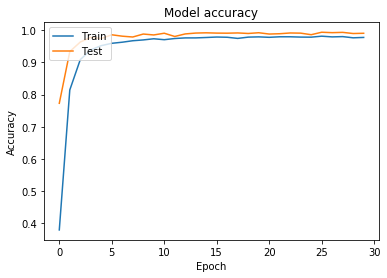

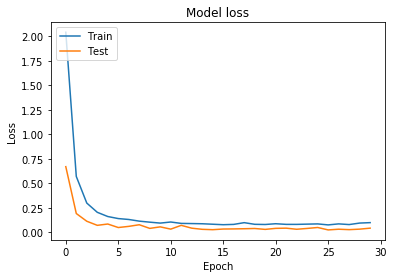

In [76]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [78]:
model.load_weights(output_dir+"/weights-improvement-26-0.99.hdf5")

In [79]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 99.35%
